# Fractionally Diferentiated Features

Método de estandarización de variables descrito en el **Capítulo 5** del libro **Advances in Financial Machine Learning** de Marcos Lopez de Prado

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from utils import Series
from tqdm.notebook import tqdm
from statsmodels.tsa.stattools import adfuller 

In [2]:
PATH = "./Data/Development dataset for Training/task1.txt"
series = Series()
series.read(PATH)

In [7]:
series1, labels1 = series.get(range(10000), 1)

In [15]:
def get_weight_ffd(d, thres, lim):
    w, k = [1.], 1
    ctr = 0
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
        ctr += 1
        if ctr == lim - 1:
            break
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

def frac_diff_ffd(x, d, thres=1e-5):
    w = get_weight_ffd(d, thres, len(x))
    width = len(w) - 1
    output = []
    output.extend([0] * width)
    for i in range(width, len(x)):
        output.append(np.dot(w.T, x[i - width:i + 1])[0])
    return np.array(output)

El parámetro $d$ marca el grado de diferenciación de la serie ($d=0$ deja la serie intacta, y $d=1$ resta a cada valor de la serie el valor de la serie en el instante anterior). Con $d=1$ estandarizamos la serie a cambio de perder la memoria. Con valores de $d$ intermedios (entre 0 y 1) podemos conseguir estandarizar la serie eliminando la menor cantidad de memoria posible.

El parámetro $thres$ es un parámetro relacionado con la "calidad de la diferenciacion". Al no disponer de una serie infinita ni poder de computación infinito, tenemos que truncar la serie de pesos (que deberia ser infinita) en un determinado "step". El parámetro $thres$ representa el valor absoluto del peso a partir del cual se dejan de tener en cuenta.

(0, 550)

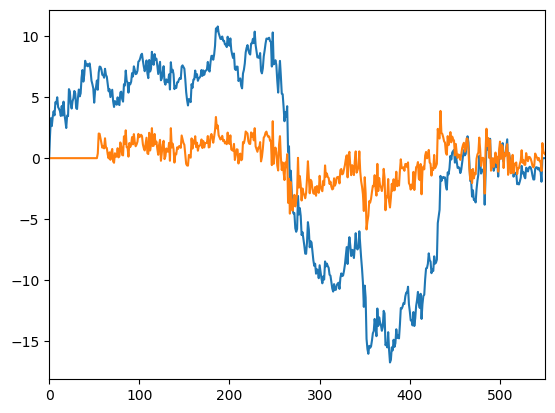

In [325]:
i = 0
frac_diff_series = frac_diff_ffd(series1[i], 0.4, thres=1e-3)
plt.plot(range(len(series1[i])), series1[i])
plt.plot(range(len(frac_diff_series)), frac_diff_series)
plt.xlim(0,550)

Observamos que al diferenciar perdemos ciertos valores iniciales. El número de valores iniciales de la serie que se pierden dependen de los parámetros $d$ y $ thres$. A menor $d$ y a menor $thres$ mas valores iniciales se pierden de la serie.

In [220]:
norm = np.zeros_like(series1)
for i in tqdm(range(len(series1))):
    norm[i,:] = frac_diff_ffd(series1[i], 0.3, thres=1e-2)

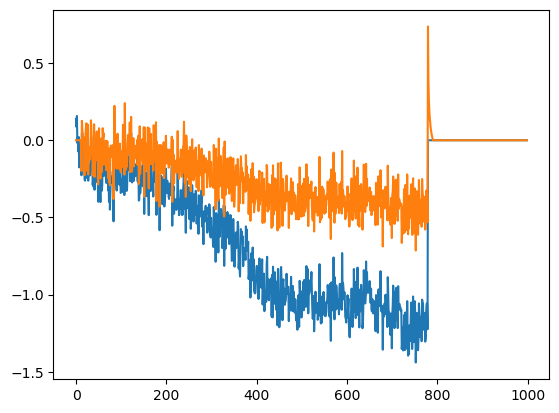

In [225]:
i = np.random.randint(10000)
plt.plot(range(len(series1[i])), series1[i])
plt.plot(range(len(norm[i])), norm[i])

In [284]:
def plot_ADF(serie, thres):
    stats = []
    serie = serie[serie!=0]
    for d in np.linspace(0,1,11):
        snorm = frac_diff_ffd(serie, d, thres=thres)
        serie = serie[snorm!=0]
        snorm = snorm[snorm!=0]
        corr = np.corrcoef(serie, snorm)[0,1]
        snorm = adfuller(snorm,maxlag=1,regression='c',autolag=None)
        stats.append(list(snorm[:4])+[snorm[4]['5%']]+[corr])
    stats = np.array(stats)
    fig, ax1 = plt.subplots(dpi=100, figsize=(5,3))
    colors = ["#6c71c4", "#2aa198", "#d33682"]
    ax1.plot(np.linspace(0,1,11), stats[:,0], color=colors[0])
    ax1.plot(np.linspace(0,1,11), stats[:,4], linestyle='--', color=colors[2])
    ax1.set_ylabel('ADF', color=colors[0])
    ax1.tick_params(axis='y', labelcolor=colors[0])
    ax1.grid(True)
    ax2 = ax1.twinx()
    ax2.plot(np.linspace(0,1,11), stats[:,5], color=colors[1])
    ax2.set_ylabel('Correlation', color=colors[1])
    ax2.tick_params(axis='y', labelcolor=colors[1])

Creamos ahora una función para calcular el valor optimo de $d$ que permite obtener una serie estacionaria preservando la máxima memoria posible. Ademas también permite observar la correlación que mantiene la serie diferenciada con respecto a la serie original.

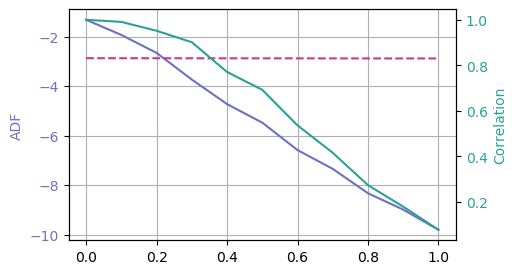

In [304]:
i = np.random.randint(10000)
plot_ADF(series1[i], thres = 1e-3)

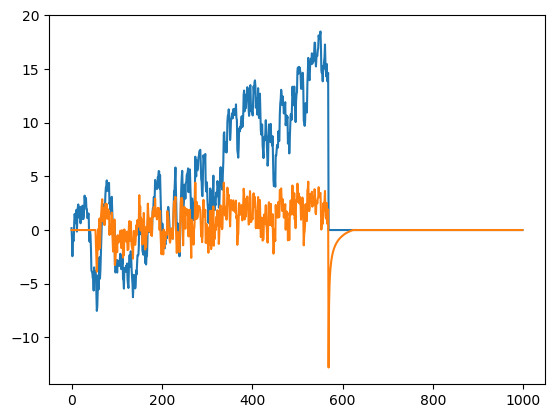

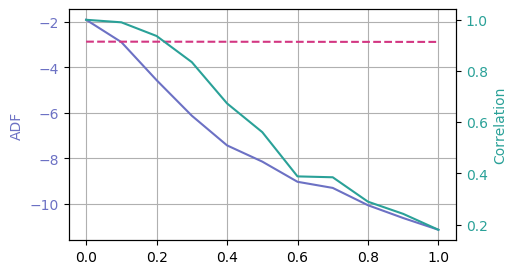

In [319]:
i = np.random.randint(10000)
thres=1e-3
frac_diff_series = frac_diff_ffd(series1[i], 0.4, thres=thres)
plt.plot(range(len(series1[i])), series1[i])
plt.plot(range(len(frac_diff_series)), frac_diff_series)
plot_ADF(series1[i], thres)